In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import sys
sys.path.append('../src')

import numpy as np
from utils import adata_train, adata_test

In [17]:
from tqdm import tqdm
import pandas as pd

import celloracle as co
oracle = co.data.load_tutorial_oracle_object()

In [12]:
import scanpy as sc 

sc.tl.pca(adata_train)
sc.pp.neighbors(adata_train)
sc.tl.draw_graph(adata_train, layout='fa')
sc.pl.draw_graph(adata_train, color='rctd_cluster')

In [13]:
adata_train

[autoreload of spaceoracle.oracles failed: Traceback (most recent call last):
  File "/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/ix/djishnu/alw399/envs/bee/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/ix/djishnu/alw399/SpaceOracle/notebooks/../src/spaceoracle/oracles.py", line 813
    def perturb(self, gene

AnnData object with n_obs × n_vars = 9043 × 1725
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'rctd_cluster_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'draw_graph'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'X_pca', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'raw_count', 'normalized_count'
    obsp: 'distances', 'connectivities'

In [14]:
import spaceoracle

so = spaceoracle.SpaceOracle(
    adata_train, 
    init_betas='ones', 
    max_epochs=25, 
    learning_rate=3e-4, 
    spatial_dim=64,
    batch_size=128,
    n_patches=2, n_heads=2, n_blocks=4, hidden_d=16
)

so.cluster_column_name = 'rctd_cluster'

🌍️ Generating spatial maps: 100%|██████████| 9043/9043 [00:33<00:00, 267.27it/s]


In [19]:
so.embedding_name = 'X_draw_graph_fr'
so.embedding = so.adata.obsm['X_draw_graph_fr']
so.cluster_column_name = 'rctd_cluster'

In [20]:
from celloracle.applications import Pseudotime_calculator

pt = Pseudotime_calculator(oracle_object=so)

In [22]:
# Instantiate pseudotime object using anndata object.
pt = Pseudotime_calculator(adata=adata_train,
                           obsm_key="X_draw_graph_fr", # Dimensional reduction data name
                           cluster_column_name="rctd_cluster" # Clustering data name
                           )

In [23]:
## For testing purposes

# co = co.data.load_tutorial_oracle_object()
# so.adata = co.adata

72


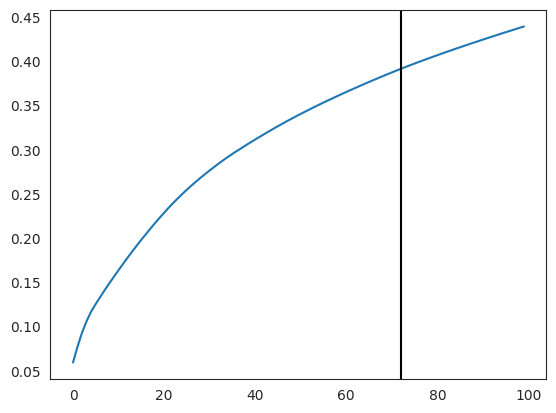

In [24]:
import matplotlib.pyplot as plt 
%matplotlib inline

# Select important PCs
plt.plot(np.cumsum(so.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(so.pca.explained_variance_ratio_))>0.002))[0][0]
print(n_comps)

plt.axvline(n_comps, c="k")
plt.show()
n_comps = min(n_comps, 50)

In [25]:
n_cell = so.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :9043
Auto-selected k is :226


In [27]:
so.knn_imputation(so.adata, so.pcs, n_pca_dims=n_comps, k=k, balanced=False, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [31]:
# coef_matrix = so.get_coef_matrix(so.adata.copy())
# perturbed_matrix = so.perturb(so.adata.to_df().values, coef_matrix, n_propagation=3)

# so.adata.layers['delta_X'] = so.adata.layers['imputed_count'] - perturbed_matrix
# so.adata.layers['delta_X'].shape

so.simulate_shift(gex_dict = {74: 0.0})

0it [00:00, ?it/s]
100%|██████████| 9043/9043 [00:00<00:00, 21704.34it/s]


In [32]:
so.estimate_transition_prob()

In [33]:
so.calculate_embedding_shift(sigma_corr=0.05)

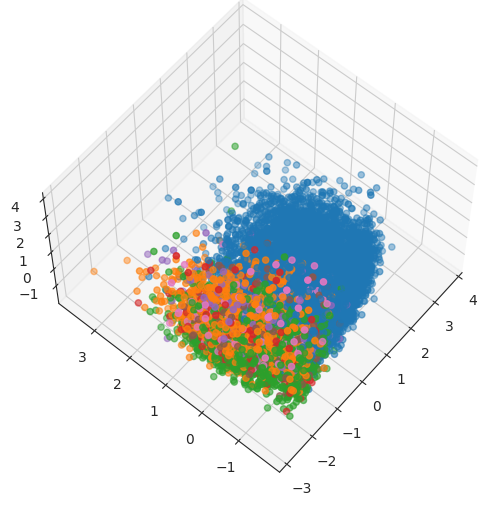

In [34]:
so.plot_pca()

In [35]:
goi = 74

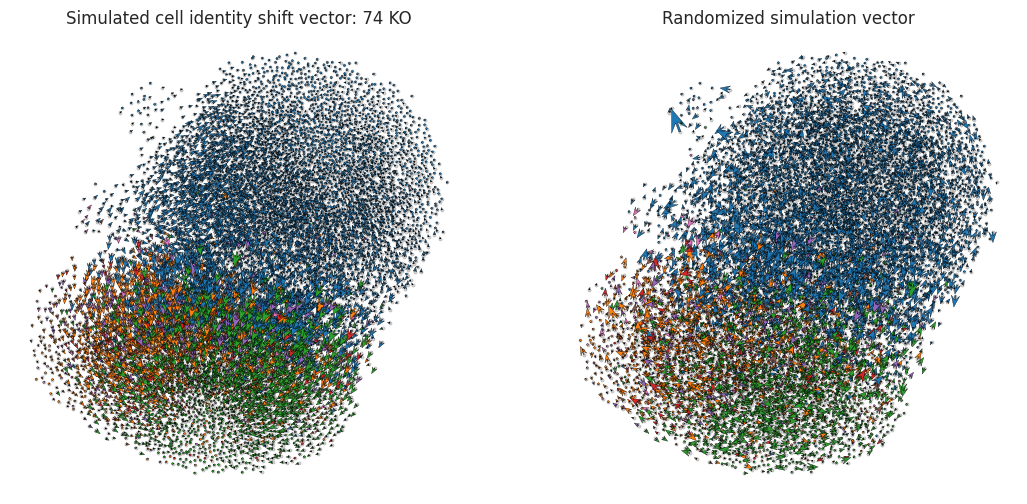

In [36]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
so.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [37]:
# n_grid = 40 is a good starting value.
n_grid = 40
so.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

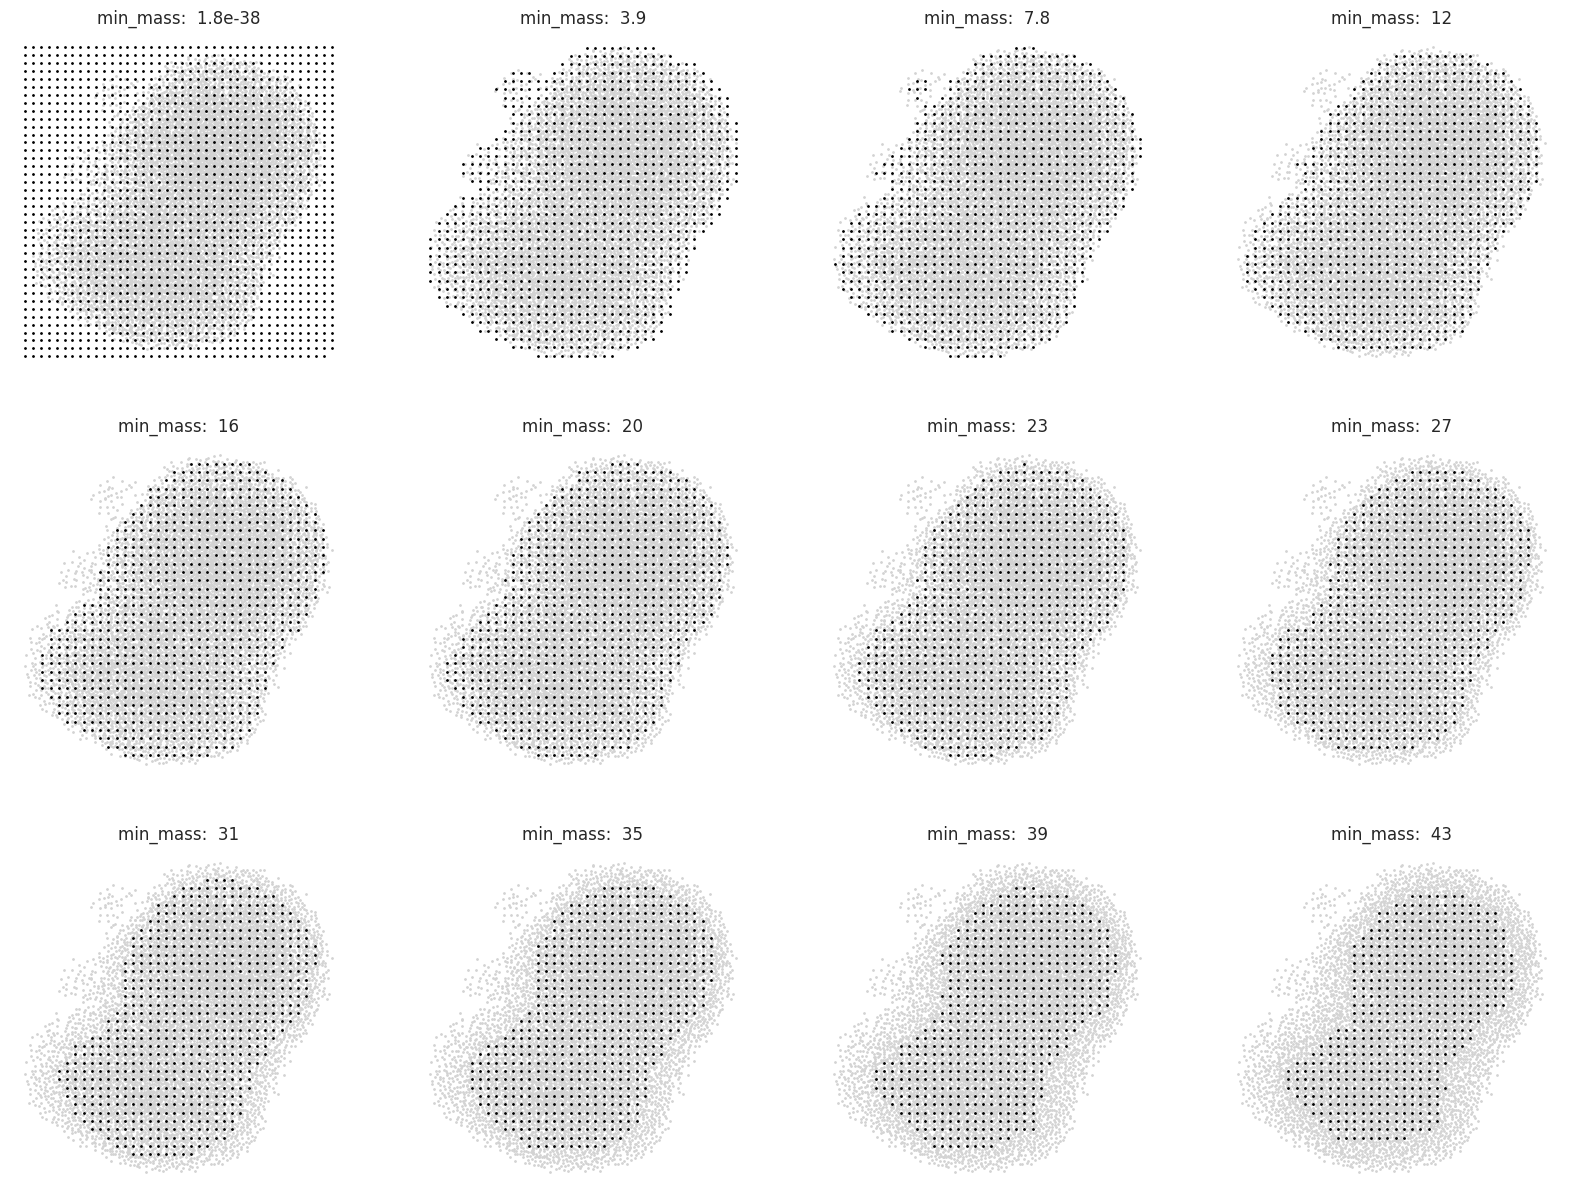

In [38]:
# Search for best min_mass.
so.suggest_mass_thresholds(n_suggestion=12)

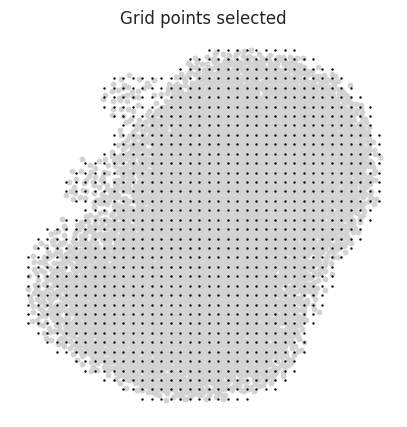

In [39]:
min_mass = 3
so.calculate_mass_filter(min_mass=min_mass, plot=True)

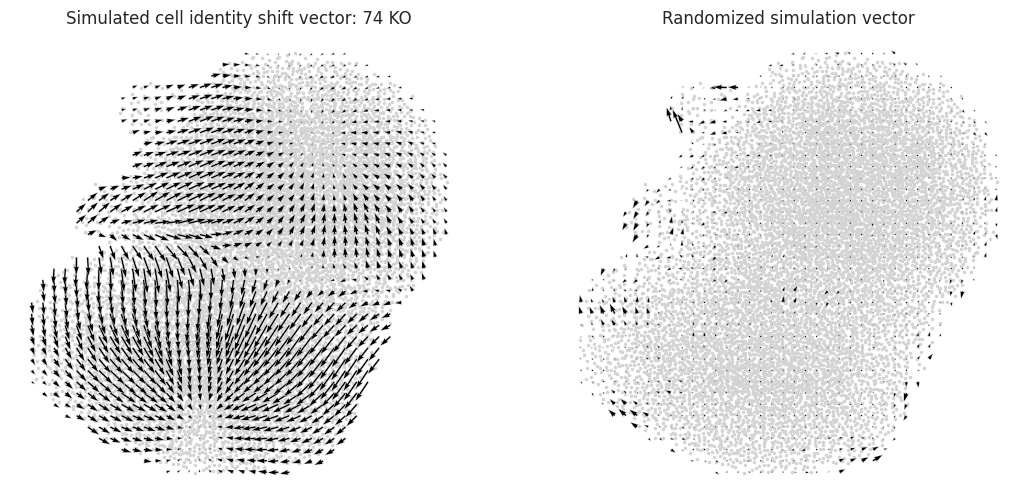

In [40]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 7
# Show quiver plot
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

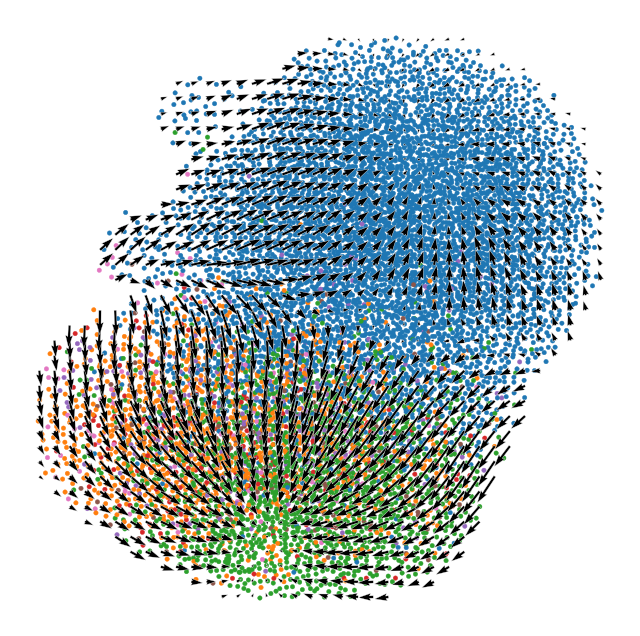

In [41]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

so.plot_cluster_whole(ax=ax, s=10)
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)